In [7]:
import sys
# sys.path.append('../')
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
import matplotlib.pyplot as plt
plt.rc('text',usetex=True)
plt.rc('font',family='serif')

from pylab import *
import pickle
from math import log
from torch.nn import parameter

import torch 
import torch.nn as nn

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

from fracturbulence.common import *
from fracturbulence.Calibration import CalibrationProblem
from fracturbulence.DataGenerator import OnePointSpectraDataGenerator

import constants.consts_exp1 as consts_exp1

from time import time

from pathlib import Path

savedir = Path().resolve() / "data" / "results" 

In [5]:
import fracturbulence as ft

In [9]:
config = {
    'type_EddyLifetime' :   'tauNet', #'TwoThird', #'tauNet', # CALIBRATION : 'tauNet',  ### 'const', TwoThird', 'Mann', 'tauNet'
    'type_PowerSpectra' :   'RDT', ### 'RDT', 'zetaNet', 'C3Net', 'Corrector'
    'nlayers'           :   2,
    'activations': [nn.ReLU(), nn.ReLU()],
    'hlayers' : [10, 10], 
    #'hidden_layer_size' :   10,
    # 'nModes'            :   5, ### number of modes in the rational function in tauNet ### deprecated
    'learn_nu'          :   False, ### NOTE: Experiment 1: False, Experiment 2: True
    'plt_tau'           :   True,
    'tol'               :   1.e-3, ### not important
    'lr'                :   1,     ### learning rate
    'penalty'           :   1, # CALIBRATION: 1.e-1,
    'regularization'    :   1.e-5,# CALIBRATION: 1.e-1,
    'nepochs'           :   10,
    'curves'            :   [0,1,2,3],
    'data_type'         :   'Kaimal',  # CALIBRATION: 'Custom', ### 'Kaimal', 'SimiuScanlan', 'SimiuYeo', 'iso'
    'spectra_file'      :   'Spectra.dat',
    'Uref'              :   10, # m/s
    'zref'              :   1, #m
    'domain'            :   torch.logspace(-1, 2, 20), #np.logspace(-4, 2, 40), ### NOTE: Experiment 1: np.logspace(-1, 2, 20), Experiment 2: np.logspace(-2, 2, 40)
    'noisy_data'        :   0.,#0*3.e-1, ### level of the data noise  ### NOTE: Experiment 1: zero, Experiment 2: non-zero
    'output_folder'     :   str(savedir), 
    'input_folder'     :   '/Users/gdeskos/work_in_progress/WindGenerator/script/'
}


[ReLU(), ReLU()]
DataValues is on 0
[format_output] -- HERE!

Calibrating MannNet...
torch.Size([80])
Initial loss:  0.09220900544903883

[Calibration.py -- calibrate]-> Epoch 0

loss  =  0.09229151893440243
loss  =  0.8423761812310617
loss  =  0.03860745709960851
loss  =  0.03846538661628935
loss  =  0.03785157630064731
loss  =  0.037817406862387576
loss  =  0.037802926039774386
loss  =  0.037802135385966995
loss  =  0.0377975066110367
loss  =  0.03779425798743209
loss  =  0.03779066122277437
loss  =  0.03778926885516972
loss  =  0.03778865811758117
loss  =  0.037788471093815015
loss  =  0.03778793370422376
loss  =  0.03780783000172506
loss  =  0.037787106587015146
loss  =  0.03778691830247735
loss  =  0.03778681218300017
loss  =  0.03778658721027371
loss  =  0.03778656428443005
loss  =  0.03778654358394636
loss  =  0.03778646325873471
loss  =  0.03778629977046103
---------------------------------



[Calibration.py -- calibrate]-> Epoch 1

loss  =  0.03778629977046103
loss  =  0.0377

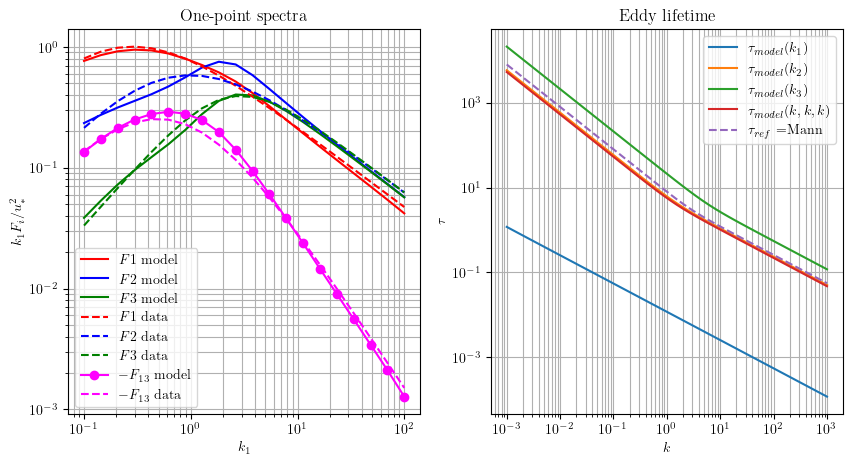

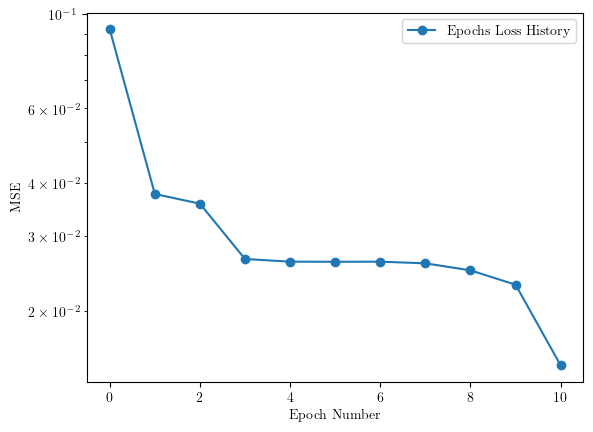

In [10]:
start = time() 

pb = CalibrationProblem(**config)
parameters = pb.parameters
parameters[:3] = [log(consts_exp1.L), log(consts_exp1.Gamma), log(consts_exp1.sigma)] #All of these parameters are positive 
    #so we can train the NN for the log of these parameters. 
pb.parameters = parameters[:len(pb.parameters)]
k1_data_pts = config['domain'] #np.logspace(-1, 2, 20)
DataPoints  = [ (k1, 1) for k1 in k1_data_pts ]
Data = OnePointSpectraDataGenerator(DataPoints=DataPoints, **config).Data

DataValues = Data[1]

IECtau=MannEddyLifetime(k1_data_pts*consts_exp1.L)
kF = pb.eval(k1_data_pts)

opt_params = pb.calibrate(Data=Data, **config)#, OptimizerClass=torch.optim.RMSprop)

plt.figure()

        #plt.plot( pb.loss_history_total, label="Total Loss History")
plt.plot( pb.loss_history_epochs, 'o-', label="Epochs Loss History")
plt.legend() 
plt.xlabel("Epoch Number")
plt.ylabel("MSE")
plt.yscale('log')

plt.show() 
